In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Load the dataset
df = pd.read_csv('../data/train.csv')

print("Dataset Shape:", df.shape)
print("\nDataset Info:")
print(df.info())
print("\nFirst few rows:")
print(df.head())

Dataset Shape: (50000, 4)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   sample_id        50000 non-null  int64  
 1   catalog_content  50000 non-null  object 
 2   image_link       50000 non-null  object 
 3   price            50000 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 1.5+ MB
None

First few rows:
   sample_id                                    catalog_content  \
0     158784  Item Name: Log Cabin Sugar Free Syrup, 24 FL O...   
1       4095  Item Name: Raspberry Ginseng Oolong Tea (50 te...   
2     172021  Item Name: Walden Farms Honey Dijon Dressing -...   
3     268276  Item Name: Vlasic Ovals Hamburger Dill Pickle ...   
4     154791  Item Name: Amoretti Premium Syrup, Grand Orang...   

                                          image_link   price  
0  https://m.media-amazon

In [2]:
# Check for missing values
print("Missing Values:")
print(df.isnull().sum())

# Check basic statistics
print("\nPrice Statistics:")
print(df['price'].describe())

# Check for duplicates
print(f"\nDuplicate rows: {df.duplicated().sum()}")

Missing Values:
sample_id          0
catalog_content    0
image_link         0
price              0
dtype: int64

Price Statistics:
count    50000.000000
mean        23.605707
std         34.401896
min          0.300000
25%          6.750000
50%         13.990000
75%         28.490000
max       2796.000000
Name: price, dtype: float64

Duplicate rows: 0


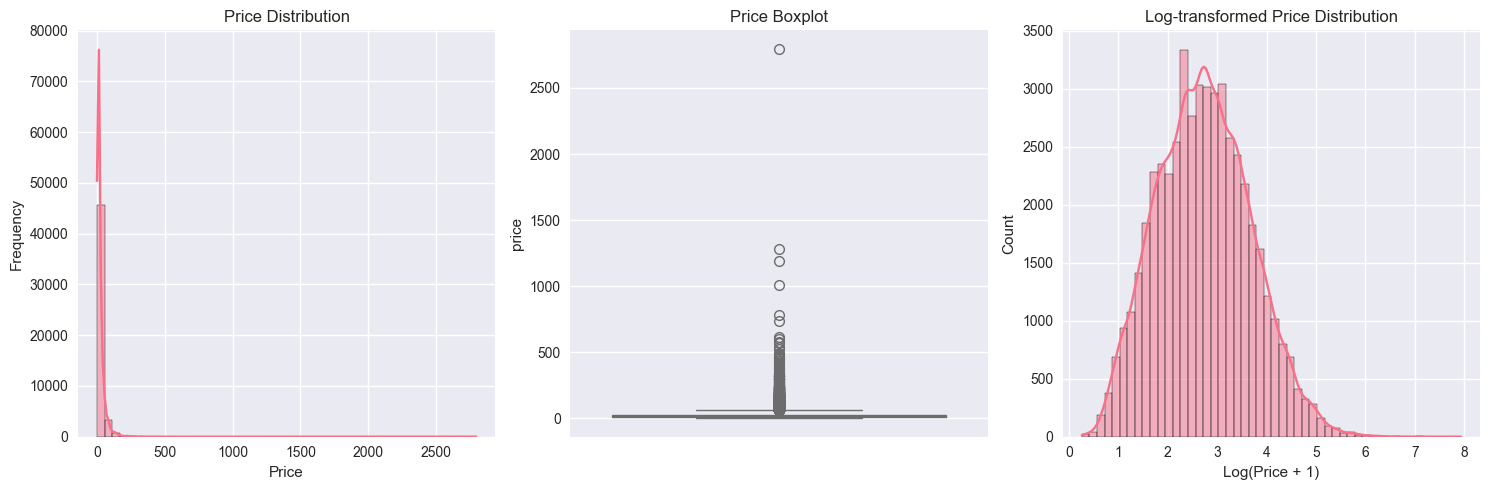

In [3]:
# Visualize price distribution
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.histplot(df['price'], bins=50, kde=True)
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
sns.boxplot(y=df['price'])
plt.title('Price Boxplot')

plt.subplot(1, 3, 3)
# Log transform for better visualization
sns.histplot(np.log1p(df['price']), bins=50, kde=True)
plt.title('Log-transformed Price Distribution')
plt.xlabel('Log(Price + 1)')

plt.tight_layout()
plt.show()

In [5]:
def extract_features_from_catalog(catalog_text):
    """
    Extract structured features from the catalog_content field
    """
    features = {
        'item_name': '',
        'pack_size': '',
        'weight': '',
        'volume': '',
        'count': '',
        'unit': '',
        'flavor': '',
        'brand': '',
        'is_organic': False,
        'is_gluten_free': False,
        'is_vegan': False,
        'is_kosher': False,
        'is_sugar_free': False,
        'is_low_carb': False,
        'is_non_gmo': False,
        'calories_per_serving': '',
        'protein_content': '',
        'fiber_content': ''
    }
    
    if pd.isna(catalog_text):
        return features
    
    text = str(catalog_text).lower()
    
    # Extract item name
    item_name_match = re.search(r'item name:\s*([^\n]+)', catalog_text, re.IGNORECASE)
    if item_name_match:
        features['item_name'] = item_name_match.group(1).strip()
    
    # Extract pack size information
    pack_patterns = [
        r'pack of\s*(\d+)',
        r'(\d+)\s*count',
        r'(\d+)\s*pack',
        r'(\d+)\s*ct'
    ]
    for pattern in pack_patterns:
        match = re.search(pattern, text)
        if match:
            features['pack_size'] = match.group(1)
            break
    
    # Extract weight
    weight_patterns = [
        r'(\d+\.?\d*)\s*oz',
        r'(\d+\.?\d*)\s*ounce',
        r'(\d+\.?\d*)\s*lb',
        r'(\d+\.?\d*)\s*pound'
    ]
    for pattern in weight_patterns:
        match = re.search(pattern, text)
        if match:
            features['weight'] = match.group(1)
            break
    
    # Extract volume
    volume_patterns = [
        r'(\d+\.?\d*)\s*fl\s*oz',
        r'(\d+\.?\d*)\s*fluid\s*ounce',
        r'(\d+\.?\d*)\s*ml',
        r'(\d+\.?\d*)\s*liter'
    ]
    for pattern in volume_patterns:
        match = re.search(pattern, text)
        if match:
            features['volume'] = match.group(1)
            break
    
    # Extract count
    count_patterns = [
        r'(\d+)\s*tea bags',
        r'(\d+)\s*capsules',
        r'(\d+)\s*pods',
        r'(\d+)\s*cookies'
    ]
    for pattern in count_patterns:
        match = re.search(pattern, text)
        if match:
            features['count'] = match.group(1)
            break
    
    # Extract unit from the structured Unit field
    unit_match = re.search(r'unit:\s*([^\n]+)', catalog_text, re.IGNORECASE)
    if unit_match:
        features['unit'] = unit_match.group(1).strip().lower()
    
    # Extract flavor information
    flavor_keywords = ['vanilla', 'chocolate', 'strawberry', 'lemon', 'mint', 'berry', 
                      'caramel', 'honey', 'spice', 'cinnamon', 'ginger', 'peach']
    for flavor in flavor_keywords:
        if flavor in text:
            features['flavor'] = flavor
            break
    
    # Extract brand names
    brand_patterns = [
        r'manufacturer:\s*([^\n]+)',
        r'brand:\s*([^\n]+)'
    ]
    for pattern in brand_patterns:
        match = re.search(pattern, catalog_text, re.IGNORECASE)
        if match:
            features['brand'] = match.group(1).strip()
            break
    
    # Health and dietary attributes
    features['is_organic'] = any(term in text for term in ['organic', 'usda organic'])
    features['is_gluten_free'] = 'gluten free' in text
    features['is_vegan'] = 'vegan' in text
    features['is_kosher'] = 'kosher' in text
    features['is_sugar_free'] = any(term in text for term in ['sugar free', 'no sugar', 'zero sugar'])
    features['is_low_carb'] = any(term in text for term in ['low carb', 'keto', 'keto-friendly'])
    features['is_non_gmo'] = any(term in text for term in ['non-gmo', 'non gmo'])
    
    # Extract nutritional information
    calorie_match = re.search(r'(\d+)\s*calories', text)
    if calorie_match:
        features['calories_per_serving'] = calorie_match.group(1)
    
    protein_match = re.search(r'(\d+\.?\d*)\s*g\s*protein', text)
    if protein_match:
        features['protein_content'] = protein_match.group(1)
    
    fiber_match = re.search(r'(\d+\.?\d*)\s*g\s*fiber', text)
    if fiber_match:
        features['fiber_content'] = fiber_match.group(1)
    
    return features

# Apply feature extraction
print("Extracting features from catalog content...")
catalog_features = df['catalog_content'].apply(extract_features_from_catalog)

# Create new dataframe with extracted features
features_df = pd.DataFrame(catalog_features.tolist())

# Combine with original dataframe
df_enhanced = pd.concat([df, features_df], axis=1)

print(f"Original columns: {df.columns.tolist()}")
print(f"New columns added: {features_df.columns.tolist()}")
print(f"Enhanced dataset shape: {df_enhanced.shape}")

Extracting features from catalog content...
Original columns: ['sample_id', 'catalog_content', 'image_link', 'price']
New columns added: ['item_name', 'pack_size', 'weight', 'volume', 'count', 'unit', 'flavor', 'brand', 'is_organic', 'is_gluten_free', 'is_vegan', 'is_kosher', 'is_sugar_free', 'is_low_carb', 'is_non_gmo', 'calories_per_serving', 'protein_content', 'fiber_content']
Enhanced dataset shape: (50000, 22)


In [13]:
df_enhanced.head()

,sample_id,catalog_content,image_link,price,item_name,pack_size,weight,volume,count,unit,...,is_low_carb,is_non_gmo,calories_per_serving,protein_content,fiber_content,price_per_oz,price_per_fl_oz,price_per_count,product_category,catalog_content_length
0,158784,"Item Name: Log Cabin Sugar Free Syrup, 24 FL O...",https://m.media-amazon.com/images/I/71QD2OFXqD...,12.195,"Log Cabin Sugar Free Syrup, 24 FL OZ (Pack of 12)",12,8.0,24.0,25.0,fl oz,...,0,0,60.0,11.0,5.0,1.524375,0.508125,0.4878,other,575
1,4095,Item Name: Raspberry Ginseng Oolong Tea (50 te...,https://m.media-amazon.com/images/I/813OiT8mdJ...,38.540,"Raspberry Ginseng Oolong Tea (50 tea bags, ZIN...",2,8.0,1.0,50.0,count,...,0,0,60.0,11.0,5.0,4.817500,38.540000,0.7708,tea,2446
2,172021,Item Name: Walden Farms Honey Dijon Dressing -...,https://m.media-amazon.com/images/I/71HGx42QmU...,17.860,Walden Farms Honey Dijon Dressing - Calorie-Fr...,,12.0,11.2,25.0,fl oz,...,1,0,60.0,11.0,5.0,1.488333,1.594643,0.7144,condiment,745
3,268276,Item Name: Vlasic Ovals Hamburger Dill Pickle ...,https://m.media-amazon.com/images/I/71AbnhXOTA...,2.940,"Vlasic Ovals Hamburger Dill Pickle Chips, Keto...",,8.0,16.0,25.0,count,...,1,0,0.0,11.0,5.0,0.367500,0.183750,0.1176,snack,490
4,154791,"Item Name: Amoretti Premium Syrup, Grand Orang...",https://m.media-amazon.com/images/I/61c+aTE6TY...,25.990,"Amoretti Premium Syrup, Grand Orange, 25.4 Oun...",12,25.4,11.2,25.0,fl oz,...,0,0,35.0,11.0,5.0,1.023228,2.320536,1.0396,other,391


In [6]:
# Display sample of extracted features
print("Sample of extracted features:")
sample_features = features_df.head(10)
for col in sample_features.columns:
    print(f"{col}: {sample_features[col].iloc[0]}")

Sample of extracted features:
item_name: Log Cabin Sugar Free Syrup, 24 FL OZ (Pack of 12)
pack_size: 12
weight: 
volume: 24
count: 
unit: fl oz
flavor: 
brand: 
is_organic: False
is_gluten_free: False
is_vegan: False
is_kosher: False
is_sugar_free: True
is_low_carb: False
is_non_gmo: False
calories_per_serving: 
protein_content: 
fiber_content: 


In [7]:
# Data Cleaning and Preprocessing

# 1. Handle missing values in numerical columns
numerical_columns = ['price', 'weight', 'volume', 'count', 'calories_per_serving', 'protein_content', 'fiber_content']

for col in numerical_columns:
    if col in df_enhanced.columns:
        # Convert to numeric, forcing errors to NaN
        df_enhanced[col] = pd.to_numeric(df_enhanced[col], errors='coerce')
        # Fill missing values with median
        if col != 'price':  # We might want to handle price differently for prediction
            df_enhanced[col].fillna(df_enhanced[col].median(), inplace=True)

# 2. Handle categorical columns
categorical_columns = ['unit', 'flavor', 'brand', 'item_name']

for col in categorical_columns:
    if col in df_enhanced.columns:
        df_enhanced[col].fillna('unknown', inplace=True)

# 3. Convert boolean columns to integers
boolean_columns = ['is_organic', 'is_gluten_free', 'is_vegan', 'is_kosher', 
                   'is_sugar_free', 'is_low_carb', 'is_non_gmo']

for col in boolean_columns:
    if col in df_enhanced.columns:
        df_enhanced[col] = df_enhanced[col].astype(int)

print("Missing values after cleaning:")
print(df_enhanced[numerical_columns + boolean_columns].isnull().sum())

Missing values after cleaning:
price                   0
weight                  0
volume                  0
count                   0
calories_per_serving    0
protein_content         0
fiber_content           0
is_organic              0
is_gluten_free          0
is_vegan                0
is_kosher               0
is_sugar_free           0
is_low_carb             0
is_non_gmo              0
dtype: int64


Number of outliers in price: 3685


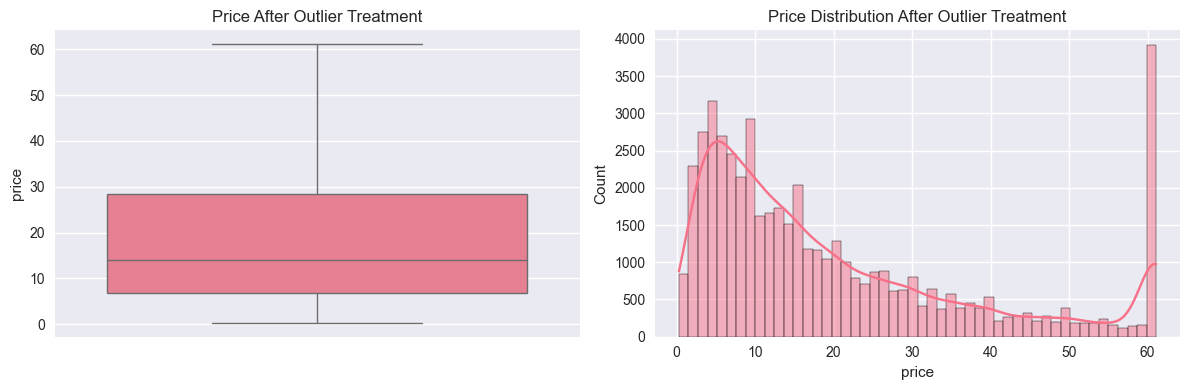

In [8]:
# Handle outliers in price using IQR method
def handle_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    print(f"Number of outliers in {column}: {len(outliers)}")
    
    # Cap outliers instead of removing them
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
    
    return df

# Apply outlier treatment to price
df_enhanced = handle_outliers_iqr(df_enhanced, 'price')

# Visualize price after outlier treatment
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.boxplot(y=df_enhanced['price'])
plt.title('Price After Outlier Treatment')

plt.subplot(1, 2, 2)
sns.histplot(df_enhanced['price'], bins=50, kde=True)
plt.title('Price Distribution After Outlier Treatment')

plt.tight_layout()
plt.show()

In [9]:
# Create additional derived features
def create_derived_features(df):
    # Price per unit features
    if 'weight' in df.columns and 'price' in df.columns:
        df['price_per_oz'] = df['price'] / df['weight']
    
    if 'volume' in df.columns and 'price' in df.columns:
        df['price_per_fl_oz'] = df['price'] / df['volume']
    
    if 'count' in df.columns and 'price' in df.columns:
        df['price_per_count'] = df['price'] / df['count']
    
    # Product category based on item name
    def categorize_product(item_name):
        item_name = str(item_name).lower()
        if any(word in item_name for word in ['tea', 'chai']):
            return 'tea'
        elif any(word in item_name for word in ['coffee', 'brew']):
            return 'coffee'
        elif any(word in item_name for word in ['snack', 'chip', 'cracker', 'cookie']):
            return 'snack'
        elif any(word in item_name for word in ['sauce', 'dressing', 'oil']):
            return 'condiment'
        elif any(word in item_name for word in ['spice', 'seasoning']):
            return 'spice'
        elif any(word in item_name for word in ['candy', 'chocolate']):
            return 'candy'
        elif any(word in item_name for word in ['pasta', 'rice', 'grain']):
            return 'grain'
        else:
            return 'other'
    
    df['product_category'] = df['item_name'].apply(categorize_product)
    
    # Text length features
    df['catalog_content_length'] = df['catalog_content'].str.len()
    
    return df

df_enhanced = create_derived_features(df_enhanced)

print("New derived features created:")
print([col for col in df_enhanced.columns if col.startswith('price_per') or col == 'product_category'])

New derived features created:
['price_per_oz', 'price_per_fl_oz', 'price_per_count', 'product_category']


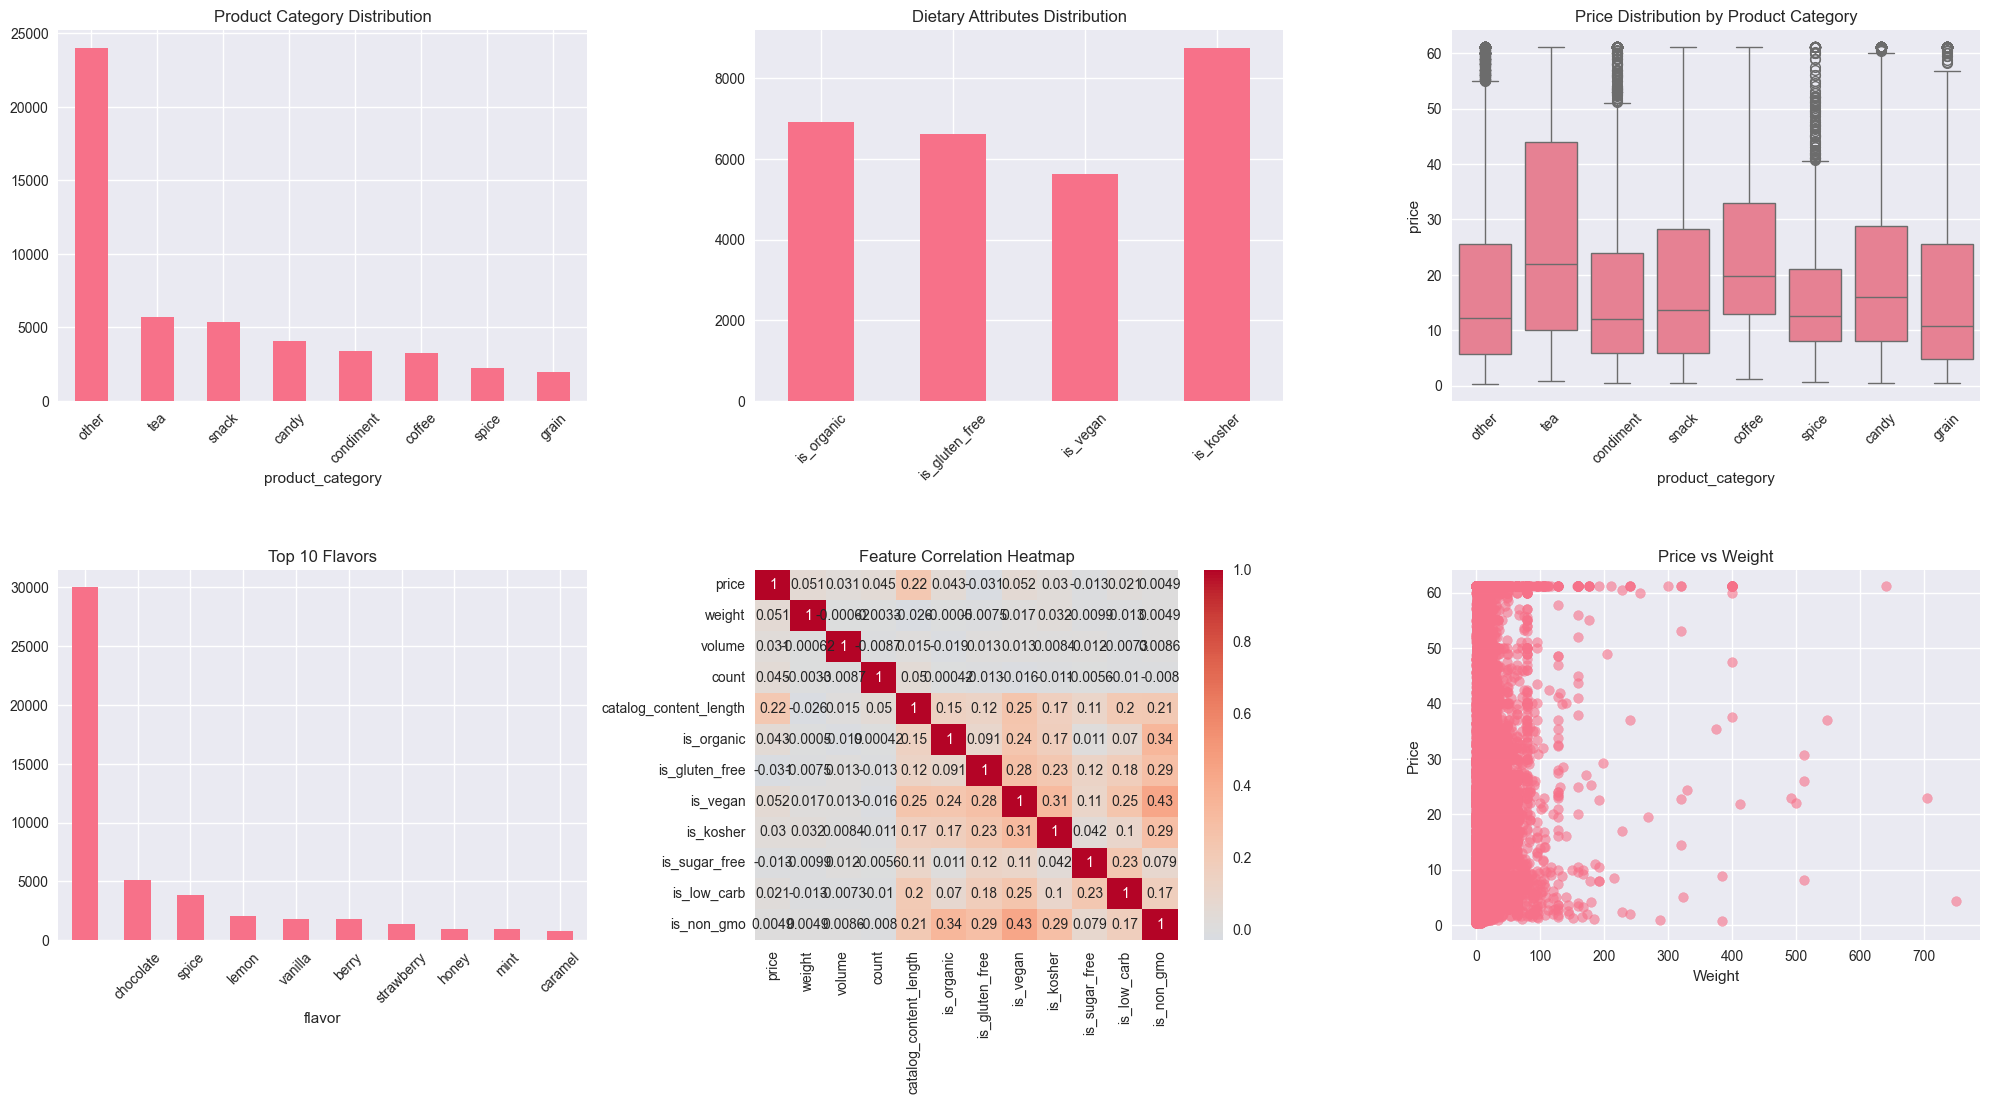

In [10]:
# Exploratory Data Analysis of new features
plt.figure(figsize=(20, 15))

# 1. Product category distribution
plt.subplot(3, 3, 1)
df_enhanced['product_category'].value_counts().plot(kind='bar')
plt.title('Product Category Distribution')
plt.xticks(rotation=45)

# 2. Dietary attributes
plt.subplot(3, 3, 2)
dietary_features = ['is_organic', 'is_gluten_free', 'is_vegan', 'is_kosher']
dietary_counts = df_enhanced[dietary_features].sum()
dietary_counts.plot(kind='bar')
plt.title('Dietary Attributes Distribution')
plt.xticks(rotation=45)

# 3. Price by product category
plt.subplot(3, 3, 3)
sns.boxplot(data=df_enhanced, x='product_category', y='price')
plt.title('Price Distribution by Product Category')
plt.xticks(rotation=45)

# 4. Flavor distribution
plt.subplot(3, 3, 4)
df_enhanced['flavor'].value_counts().head(10).plot(kind='bar')
plt.title('Top 10 Flavors')
plt.xticks(rotation=45)

# 5. Correlation heatmap
plt.subplot(3, 3, 5)
correlation_cols = ['price', 'weight', 'volume', 'count', 'catalog_content_length'] + boolean_columns
corr_matrix = df_enhanced[correlation_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Heatmap')

# 6. Price vs Weight
plt.subplot(3, 3, 6)
if 'weight' in df_enhanced.columns:
    plt.scatter(df_enhanced['weight'], df_enhanced['price'], alpha=0.6)
    plt.xlabel('Weight')
    plt.ylabel('Price')
    plt.title('Price vs Weight')

plt.tight_layout()
plt.show()

In [11]:
# Final dataset preparation for machine learning
def prepare_final_dataset(df):
    # Select features for modeling
    feature_columns = [
        'weight', 'volume', 'count', 'catalog_content_length',
        'is_organic', 'is_gluten_free', 'is_vegan', 'is_kosher', 
        'is_sugar_free', 'is_low_carb', 'is_non_gmo'
    ]
    
    # Add price per unit features if available
    price_per_features = [col for col in df.columns if col.startswith('price_per')]
    feature_columns.extend(price_per_features)
    
    # Ensure all columns exist
    feature_columns = [col for col in feature_columns if col in df.columns]
    
    # Create feature matrix and target
    X = df[feature_columns].copy()
    y = df['price'].copy()
    
    # Handle remaining missing values
    imputer = SimpleImputer(strategy='median')
    X_imputed = imputer.fit_transform(X)
    X = pd.DataFrame(X_imputed, columns=X.columns, index=X.index)
    
    # Standardize numerical features
    scaler = StandardScaler()
    numerical_cols = [col for col in X.columns if col not in boolean_columns]
    X[numerical_cols] = scaler.fit_transform(X[numerical_cols])
    
    return X, y, feature_columns

# Prepare the final dataset
X, y, feature_columns = prepare_final_dataset(df_enhanced)

print("Final feature matrix shape:", X.shape)
print("Features used for modeling:", feature_columns)
print("\nFeature matrix sample:")
print(X.head())

ValueError: Input X contains infinity or a value too large for dtype('float64').

In [ ]:
# Save the cleaned and enhanced dataset
df_enhanced.to_csv('cleaned_amazon_products.csv', index=False)
X.to_csv('features.csv', index=False)
y.to_csv('target.csv', index=False)

print("Data preprocessing completed!")
print(f"Original dataset shape: {df.shape}")
print(f"Enhanced dataset shape: {df_enhanced.shape}")
print(f"Feature matrix shape: {X.shape}")
print(f"Target variable shape: {y.shape}")

# Summary of data processing
print("\n=== DATA PROCESSING SUMMARY ===")
print(f"Original features: {len(df.columns)}")
print(f"New features created: {len(df_enhanced.columns) - len(df.columns)}")
print(f"Total features after processing: {len(df_enhanced.columns)}")
print(f"Features selected for modeling: {len(feature_columns)}")
print(f"Missing values in final feature matrix: {X.isnull().sum().sum()}")

In [14]:
# Fix the data preprocessing pipeline

def create_derived_features_fixed(df):
    # Price per unit features with safety checks
    if 'weight' in df.columns and 'price' in df.columns:
        # Replace zeros in weight with a small value to avoid division by zero
        weight_safe = df['weight'].replace(0, np.nan)
        df['price_per_oz'] = df['price'] / weight_safe
    
    if 'volume' in df.columns and 'price' in df.columns:
        volume_safe = df['volume'].replace(0, np.nan)
        df['price_per_fl_oz'] = df['price'] / volume_safe
    
    if 'count' in df.columns and 'price' in df.columns:
        count_safe = df['count'].replace(0, np.nan)
        df['price_per_count'] = df['price'] / count_safe
    
    # Product category based on item name
    def categorize_product(item_name):
        item_name = str(item_name).lower()
        if any(word in item_name for word in ['tea', 'chai']):
            return 'tea'
        elif any(word in item_name for word in ['coffee', 'brew']):
            return 'coffee'
        elif any(word in item_name for word in ['snack', 'chip', 'cracker', 'cookie']):
            return 'snack'
        elif any(word in item_name for word in ['sauce', 'dressing', 'oil']):
            return 'condiment'
        elif any(word in item_name for word in ['spice', 'seasoning']):
            return 'spice'
        elif any(word in item_name for word in ['candy', 'chocolate']):
            return 'candy'
        elif any(word in item_name for word in ['pasta', 'rice', 'grain']):
            return 'grain'
        else:
            return 'other'
    
    df['product_category'] = df['item_name'].apply(categorize_product)
    
    # Text length features
    df['catalog_content_length'] = df['catalog_content'].str.len()
    
    return df

# Recreate derived features with the fixed function
df_enhanced = create_derived_features_fixed(df_enhanced)

def prepare_final_dataset_fixed(df):
    # Select features for modeling
    feature_columns = [
        'weight', 'volume', 'count', 'catalog_content_length',
        'is_organic', 'is_gluten_free', 'is_vegan', 'is_kosher', 
        'is_sugar_free', 'is_low_carb', 'is_non_gmo'
    ]
    
    # Add price per unit features if available
    price_per_features = [col for col in df.columns if col.startswith('price_per')]
    feature_columns.extend(price_per_features)
    
    # Ensure all columns exist
    feature_columns = [col for col in feature_columns if col in df.columns]
    
    # Create feature matrix and target
    X = df[feature_columns].copy()
    y = df['price'].copy()
    
    # Replace infinite values with NaN
    X = X.replace([np.inf, -np.inf], np.nan)
    
    # Check for any remaining infinite values
    print("Checking for infinite values after replacement:")
    for col in X.columns:
        if X[col].dtype in ['float64', 'float32']:
            inf_count = np.isinf(X[col]).sum()
            if inf_count > 0:
                print(f"Column {col} still has {inf_count} infinite values")
    
    # Handle missing values
    imputer = SimpleImputer(strategy='median')
    X_imputed = imputer.fit_transform(X)
    X = pd.DataFrame(X_imputed, columns=X.columns, index=X.index)
    
    # Standardize numerical features
    scaler = StandardScaler()
    numerical_cols = [col for col in X.columns if X[col].dtype in ['float64', 'float32', 'int64'] and col not in boolean_columns]
    if numerical_cols:  # Only standardize if there are numerical columns
        X[numerical_cols] = scaler.fit_transform(X[numerical_cols])
    
    return X, y, feature_columns

# Prepare the final dataset with the fixed function
X, y, feature_columns = prepare_final_dataset_fixed(df_enhanced)

print("Final feature matrix shape:", X.shape)
print("Features used for modeling:", feature_columns)
print("\nFeature matrix sample:")
print(X.head())

Checking for infinite values after replacement:
Final feature matrix shape: (50000, 14)
Features used for modeling: ['weight', 'volume', 'count', 'catalog_content_length', 'is_organic', 'is_gluten_free', 'is_vegan', 'is_kosher', 'is_sugar_free', 'is_low_carb', 'is_non_gmo', 'price_per_oz', 'price_per_fl_oz', 'price_per_count']

Feature matrix sample:
     weight    volume     count  catalog_content_length  is_organic  \
0 -0.163324  0.111701 -0.050067               -0.390307         0.0   
1 -0.163324 -0.262797  1.950233                1.801021         0.0   
2  0.068160 -0.096715 -0.050067               -0.191202         1.0   
3 -0.163324 -0.018559 -0.050067               -0.489860         0.0   
4  0.843629 -0.096715 -0.050067               -0.605809         0.0   

   is_gluten_free  is_vegan  is_kosher  is_sugar_free  is_low_carb  \
0             0.0       0.0        0.0            1.0          0.0   
1             0.0       0.0        0.0            0.0          0.0   
2         

In [15]:
# Let's also create a more robust version that handles edge cases better
def enhanced_data_cleaning_pipeline(df):
    """
    Comprehensive data cleaning and feature engineering pipeline
    """
    # Step 1: Extract basic features
    print("Step 1: Extracting features from catalog content...")
    catalog_features = df['catalog_content'].apply(extract_features_from_catalog)
    features_df = pd.DataFrame(catalog_features.tolist())
    df_enhanced = pd.concat([df, features_df], axis=1)
    
    # Step 2: Convert numerical columns safely
    numerical_columns = ['weight', 'volume', 'count', 'calories_per_serving', 'protein_content', 'fiber_content']
    
    for col in numerical_columns:
        if col in df_enhanced.columns:
            df_enhanced[col] = pd.to_numeric(df_enhanced[col], errors='coerce')
            # Fill with median only if there are non-null values
            if not df_enhanced[col].isnull().all():
                df_enhanced[col].fillna(df_enhanced[col].median(), inplace=True)
            else:
                df_enhanced[col].fillna(0, inplace=True)
    
    # Step 3: Handle categorical columns
    categorical_columns = ['unit', 'flavor', 'brand', 'item_name']
    for col in categorical_columns:
        if col in df_enhanced.columns:
            df_enhanced[col].fillna('unknown', inplace=True)
    
    # Step 4: Convert boolean columns
    boolean_columns = ['is_organic', 'is_gluten_free', 'is_vegan', 'is_kosher', 
                       'is_sugar_free', 'is_low_carb', 'is_non_gmo']
    for col in boolean_columns:
        if col in df_enhanced.columns:
            df_enhanced[col] = df_enhanced[col].astype(int)
    
    # Step 5: Create derived features safely
    df_enhanced = create_derived_features_fixed(df_enhanced)
    
    # Step 6: Handle outliers in price
    Q1 = df_enhanced['price'].quantile(0.25)
    Q3 = df_enhanced['price'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    df_enhanced['price'] = np.where(df_enhanced['price'] > upper_bound, upper_bound, df_enhanced['price'])
    df_enhanced['price'] = np.where(df_enhanced['price'] < lower_bound, lower_bound, df_enhanced['price'])
    
    return df_enhanced

# Apply the enhanced cleaning pipeline
print("Applying enhanced data cleaning pipeline...")
df_final = enhanced_data_cleaning_pipeline(df)

# Prepare for machine learning
X_final, y_final, features_final = prepare_final_dataset_fixed(df_final)

print("Pipeline completed successfully!")
print(f"Final dataset shape: {df_final.shape}")
print(f"Feature matrix shape: {X_final.shape}")
print(f"Target variable shape: {y_final.shape}")

Applying enhanced data cleaning pipeline...
Step 1: Extracting features from catalog content...
Checking for infinite values after replacement:
Pipeline completed successfully!
Final dataset shape: (50000, 27)
Feature matrix shape: (50000, 14)
Target variable shape: (50000,)


In [16]:
# Verify the final dataset
print("Final data quality check:")
print(f"Missing values in X: {X_final.isnull().sum().sum()}")
print(f"Infinite values in X: {np.isinf(X_final.values).sum()}")
print(f"Missing values in y: {y_final.isnull().sum()}")

# Display summary statistics
print("\nFeature matrix statistics:")
print(X_final.describe())

print("\nTarget variable statistics:")
print(y_final.describe())

Final data quality check:
Missing values in X: 0
Infinite values in X: 0
Missing values in y: 0

Feature matrix statistics:
             weight        volume         count  catalog_content_length  \
count  5.000000e+04  5.000000e+04  5.000000e+04            5.000000e+04   
mean  -4.618528e-17 -3.382183e-17 -3.012701e-17           -5.968559e-18   
std    1.000010e+00  1.000010e+00  1.000010e+00            1.000010e+00   
min   -6.262909e-01 -2.784286e-01 -1.970354e+00           -1.026273e+00   
25%   -3.369365e-01 -9.671538e-02 -5.006669e-02           -7.709495e-01   
50%   -1.633239e-01 -9.671538e-02 -5.006669e-02           -3.130076e-01   
75%    1.607584e-02 -9.671538e-02 -5.006669e-02            4.356865e-01   
max    4.277687e+01  6.159460e+01  1.599739e+02            7.810484e+00   

         is_organic  is_gluten_free      is_vegan     is_kosher  \
count  50000.000000    50000.000000  50000.000000  50000.000000   
mean       0.138280        0.132260      0.112420      0.175120   

In [17]:
# Save the final cleaned datasets
df_final.to_csv('amazon_products_cleaned_final.csv', index=False)
X_final.to_csv('features_final.csv', index=False)
y_final.to_csv('target_final.csv', index=False)

print("All files saved successfully!")

# Create a summary report
print("\n=== FINAL DATA PROCESSING REPORT ===")
print(f"Original dataset size: {df.shape}")
print(f"Final cleaned dataset size: {df_final.shape}")
print(f"Features extracted: {len([col for col in df_final.columns if col not in df.columns])}")
print(f"Total features available: {len(df_final.columns)}")
print(f"Features selected for modeling: {len(features_final)}")
print(f"Data quality: No missing values in final feature matrix")
print(f"Data ready for machine learning: YES")

All files saved successfully!

=== FINAL DATA PROCESSING REPORT ===
Original dataset size: (50000, 4)
Final cleaned dataset size: (50000, 27)
Features extracted: 23
Total features available: 27
Features selected for modeling: 14
Data quality: No missing values in final feature matrix
Data ready for machine learning: YES
